In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/home/jupyter')
sys.path.append('/home/jupyter/checkmate-histo')
sys.path.append('/home/jupyter/slide-alignment')

from checkmate_imports import *

In [5]:
from skimage.transform import rescale, resize, downscale_local_mean
from slide_alignment.utils import create_img_from_qptiff, match_image_size, displace_image, make_tiles_from_array, write_tiles_to_pickle
def get_separated_heatmaps_simplified(plotting_df, col):
    x_max, y_max = plotting_df[['x','y']].max()
    placeholder = np.ones((y_max+1, x_max+1))*-1
    for (x,y), row in plotting_df.set_index(['x','y']).iterrows():
        placeholder[y,x] = row[col]

    return placeholder


tilewise = pd.read_csv('/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/inference_outputs/ccrcc_51_immunoprofile_passing_twostage_segmentation_tile_level_info.csv')
tilewise['case_id'] = tilewise['unique_id'].apply(lambda x: x.split('_HnE')[0])

In [6]:
import tifffile
from tifffile import TiffFile

In [8]:
candidates = pd.read_csv('./immunoprofile_hne_rag_features__passing_14_subset.csv', index_col=0)

### Systematize Mapping from H&E Data Segmentations to mIF 

In [9]:
candidates

unique_id          x          y     Unnamed: 0  \
case_id                                                                     
IP_19_D00209  IP_19_D00209_HnE_Scan1  38.172558  63.779823   19431.168876   
IP_20_F00356  IP_20_F00356_HnE_Scan1  21.818327  62.308523  127268.168467   
IP_19_K00367  IP_19_K00367_HnE_Scan1  41.200726  50.557437   83952.692060   
IP_19_F00568  IP_19_F00568_HnE_Scan2  31.125115  81.573407   36219.450600   
IP_20_J00195  IP_20_J00195_HnE_Scan2  36.247559  33.113668  131488.854254   
IP_19_G00562  IP_19_G00562_HnE_Scan1  40.458422  63.172708   48188.058280   
IP_20_M00245  IP_20_M00245_HnE_Scan1  63.332520  64.469106  135974.482927   
IP_19_G00660  IP_19_G00660_HnE_Scan1  34.712766  43.305319   52488.700000   
IP_19_J00132  IP_19_J00132_HnE_Scan1  45.872958  20.050817   56053.010889   
IP_19_E00218  IP_19_E00218_HnE_Scan1  40.799213  48.088583   23910.208661   
IP_19_K00058  IP_19_K00058_HnE_Scan1  33.097500  57.467500   65238.605000   
IP_18_A00093  IP_18_A00093_HnE_Scan1  57.498623  35.030303    1752.683196   
IP_19_R00053  IP_19_R00053_HnE_Scan1  56.372168  49.349515   95253.731392   
IP_19_T00810  IP_19_T00810_HnE_Scan1  27.162896  51.868778  116936.506787   

              prob_tumor  prob_g4_not_g2  smoothed_prob_tumor  \
case_id                                                         
IP_19_D00209    0.857789        0.365244             0.857047   
IP_20_F00356    0.809354        0.547761             0.807618   
IP_19_K00367    0.747509        0.286512             0.747289   
IP_19_F00568    0.797154        0.563168             0.793246   
IP_20_J00195    0.770185        0.247417             0.766939   
IP_19_G00562    0.767208        0.219847             0.764010   
IP_20_M00245    0.763286        0.138361             0.761489   
IP_19_G00660    0.717068        0.457918             0.718643   
IP_19_J00132    0.852931        0.141997             0.855883   
IP_19_E00218    0.805572        0.239409             0.802905   
IP_19_K00058    0.747238        0.263013             0.740013   
IP_18_A00093    0.718303        0.341941             0.713948   
IP_19_R00053    0.799829        0.286256             0.788253   
IP_19_T00810    0.719041        0.103361             0.726241   

              smoothed_prob_g4_not_g2  tumor_seg_label  merge_thresh  ...  \
case_id                                                               ...   
IP_19_D00209                 0.363512        20.375552          0.35  ...   
IP_20_F00356                 0.548870        13.115246          0.35  ...   
IP_19_K00367                 0.284006        10.469972          0.35  ...   
IP_19_F00568                 0.565321        11.000000          0.35  ...   
IP_20_J00195                 0.240481         2.262204          0.35  ...   
IP_19_G00562                 0.216030         1.000000          0.35  ...   
IP_20_M00245                 0.129088         9.000000          0.35  ...   
IP_19_G00660                 0.463886         6.526596          0.35  ...   
IP_19_J00132                 0.133428         8.000000          0.35  ...   
IP_19_E00218                 0.234880        11.596457          0.35  ...   
IP_19_K00058                 0.257773         5.000000          0.35  ...   
IP_18_A00093                 0.339200         9.000000          0.35  ...   
IP_19_R00053                 0.286350        11.915858          0.35  ...   
IP_19_T00810                 0.080279         7.000000          0.35  ...   

              edge_class_proximal_f_weighted  combined_edge_total  other  \
case_id                                                                    
IP_19_D00209                        0.083342                  1.0  Scan1   
IP_20_F00356                        0.000000                  0.0  Scan1   
IP_19_K00367                        0.000000                  0.0  Scan1   
IP_19_F00568                        0.464320                  1.0  Scan2   
IP_20_J00195                        0.000000                  1.

In [10]:
# load full res tif
# case_id = 'IP_19_F00568'
# case_id = 'IP_19_E00218'
case_id = 'IP_19_R00053'
initial_series_idx = 0

# mif_path = '/mnt/disks/image_data/immunoprofile/raw_files/IP_19_F00568_Scan1.qptiff'
# mif_image = TiffFile(mif_path).series[0].levels[initial_series_idx].asarray()

# load downscaled WSI for H&E and mIF used in alignment; then load produced displacement field
loaded_hne_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/hne_series4.npy')
loaded_mif_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/mif_series4.npy')

displacement_path = f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/displacement.pth'
displacement = torch.load(displacement_path, map_location='cpu')





In [11]:
def get_seg_map(plotting_df, col):
    x_min, y_min = plotting_df[['x','y']].min()
    x_max, y_max = plotting_df[['x','y']].max()
    
    print(x_min, x_max)
    print(y_min, y_max)
    
    width = x_max
    height = y_max
    
    placeholder = np.ones((height+1, width+1))*-1
    for (x,y), row in plotting_df.set_index(['x','y']).iterrows():
        placeholder[y,x] = row[col]

    return placeholder[y_min:, x_min:]

In [12]:
# get seg map
tile_df = tilewise.set_index('case_id').loc[case_id]
adjusted_seg_map_prev = get_separated_heatmaps_simplified(tile_df,'merged_labels') + 1
adjusted_seg_map = get_seg_map(tile_df,'merged_labels') + 1

resized_seg = resize(adjusted_seg_map, loaded_hne_series4.shape[:2], order=0)  # maybe can KNR on this in same sense??? 
stacked_resized_seg = np.repeat(np.expand_dims(resized_seg,-1), 3, -1)

2 75
6 100


In [13]:
adjusted_seg_map.shape

(95, 74)

In [14]:
adjusted_seg_map_prev.shape

(101, 76)

In [15]:
108*32

3456

In [16]:
loaded_hne_series4.shape[:2]

(3825, 2640)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


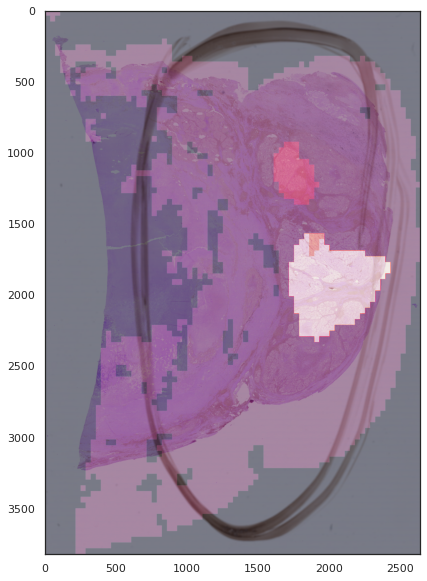

In [17]:
plt.imshow(loaded_hne_series4)
plt.imshow(resized_seg, alpha=0.5)

In [18]:
case_id

'IP_19_R00053'

In [19]:
mask_use_path = f'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/histoqc_outputs_ccrcc_51_immunoprofile/{case_id}*/*mask_use*'
mask_use_path = glob(mask_use_path)[0]

In [20]:
mask_use_image = plt.imread(mask_use_path)

In [21]:
mask_use_image.shape

(3825, 2640)

In [22]:
[x/32 for x in mask_use_image.shape]

[119.53125, 82.5]

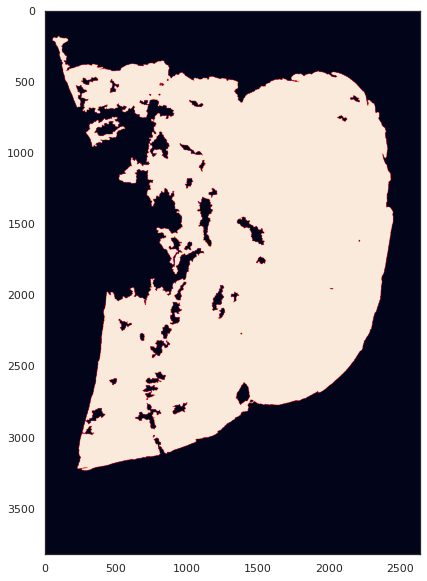

In [23]:
plt.imshow(mask_use_image)

In [24]:
mask_coords = np.array(np.where(mask_use_image.astype(bool))).transpose()

In [25]:
mask_coords[:,0].min(), mask_coords[:,1].min()

(183, 52)

In [26]:
mask_coords[:,0].max(), mask_coords[:,1].max()

(3237, 2445)

In [27]:
y_start = mask_coords[:,0].min()
y_end = mask_coords[:,0].max()

x_start = mask_coords[:,1].min()
x_end = mask_coords[:,1].max()

trimmed_mask_use = mask_use_image[y_start:y_end,x_start:x_end]

In [28]:
mask_use_image.shape

(3825, 2640)

In [29]:
trimmed_mask_use.shape

(3054, 2393)

In [30]:
adjusted_seg_map.shape

(95, 74)

In [31]:
adjusted_seg_map_prev.shape

(101, 76)

In [32]:
[x/32 for x in mask_use_image.shape]

[119.53125, 82.5]

In [33]:
[x/32 for x in loaded_hne_series4.shape[:2]]

[119.53125, 82.5]

In [34]:
[x/32 for x in trimmed_mask_use.shape]

[95.4375, 74.78125]

In [35]:
[x*32 for x in adjusted_seg_map.shape]

[3040, 2368]

In [36]:
3498*16

55968

In [37]:
(3498*16)//512

109

In [38]:
(3498*16)%512

160

In [39]:
(3456*16)//512

108

In [40]:
(3456*16)%512

0

In [41]:
adjusted_seg_map.shape

(95, 74)

In [42]:
trimmed_mask_use.shape[0]/adjusted_seg_map.shape[0]

32.14736842105263

In [43]:
trimmed_mask_use.shape[1]/adjusted_seg_map.shape[1]

32.33783783783784

In [44]:
mask_use_image.shape[0]/adjusted_seg_map.shape[0]

40.26315789473684

In [45]:
mask_use_image.shape[1]/adjusted_seg_map.shape[1]

35.67567567567568

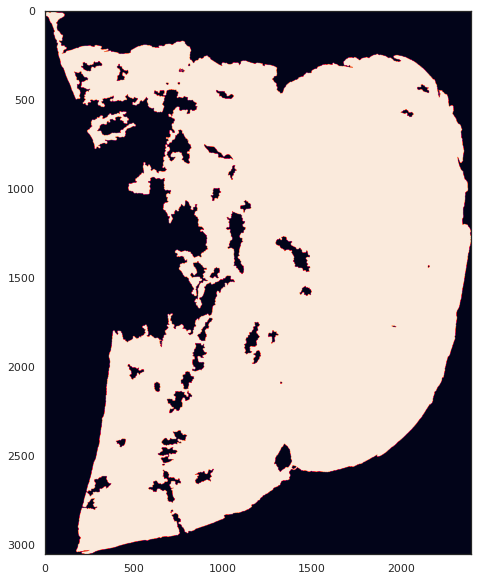

In [46]:
plt.imshow(trimmed_mask_use)

In [47]:
loaded_hne_series4.shape[0]

3825

In [48]:
alt_rescale = rescale(adjusted_seg_map, 32., order=0)

In [49]:
alt_rescale.shape

(3040, 2368)

In [50]:
mask_use_image.shape

(3825, 2640)

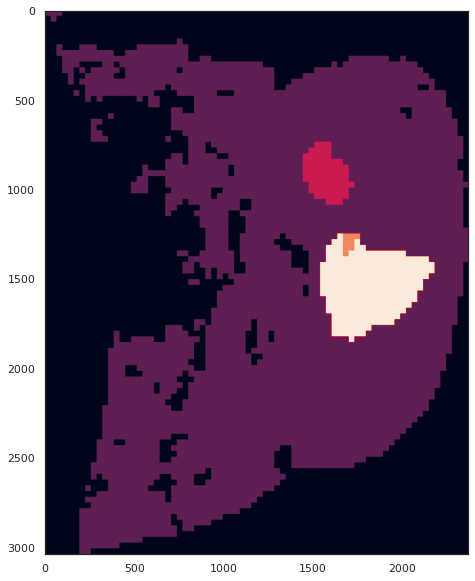

In [51]:
plt.imshow(alt_rescale)

In [52]:
resized_seg = resize(adjusted_seg_map, loaded_hne_series4.shape[:2], order=0)  # maybe can KNR on this in same sense??? 

In [60]:
3510*8

28080

In [87]:
def get_seg_map(plotting_df, col):
    x_min, y_min = plotting_df[['x','y']].min()
    x_max, y_max = plotting_df[['x','y']].max()

    # print('y_min,x_min: ', y_min,x_min)
    # print('y_max,x_max: ', y_max,x_max)
    
    width = x_max
    height = y_max
    
    placeholder = np.ones((height+1, width+1))*-1
    for (x,y), row in plotting_df.set_index(['x','y']).iterrows():
        placeholder[y,x] = row[col]

    return placeholder[y_min:, x_min:], y_max, x_max

In [96]:
initial_series_idx = 0
for case_id in candidates.index.values:
# for case_id in ['IP_19_T00810']:
    # load downscaled WSI for H&E and mIF used in alignment; then load produced displacement field
    loaded_hne_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/hne_series4.npy')
    loaded_mif_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/mif_series4.npy')

    # displacement_path = f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/displacement.pth'
    # displacement = torch.load(displacement_path, map_location='cpu')

    mask_use_path = f'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/histoqc_outputs_ccrcc_51_immunoprofile/{case_id}*/*mask_use*'
    mask_use_path = glob(mask_use_path)[0]
    mask_use_image = plt.imread(mask_use_path)
    
    

    # get seg map
    tile_df = tilewise.set_index('case_id').loc[case_id]
    adjusted_seg_map_prev = get_separated_heatmaps_simplified(tile_df,'merged_labels') + 1
    adjusted_seg_map, ymax, xmax = get_seg_map(tile_df,'merged_labels')
    adjusted_seg_map += 1 
    
    if (ymax > loaded_hne_series4.shape[0]//32) | (xmax > loaded_hne_series4.shape[1]//32):
        print('xxx')
    else:
        print(f'replacing {ymax} with {loaded_hne_series4.shape[0]//32}')
        print(f'replacing {xmax} with {loaded_hne_series4.shape[1]//32}\n')
     
    # print(loaded_hne_series4.shape, mask_use_image.shape)
    # print([x/32 for x in loaded_hne_series4.shape[:2]])
    # print(adjusted_seg_map.shape, adjusted_seg_map_prev.shape,'\n')

    resized_seg = resize(adjusted_seg_map, loaded_hne_series4.shape[:2], order=0)  # maybe can KNR on this in same sense??? 
    stacked_resized_seg = np.repeat(np.expand_dims(resized_seg,-1), 3, -1)


replacing 106 with 109
replacing 88 with 91

replacing 121 with 123
replacing 72 with 76

replacing 105 with 111
replacing 81 with 82

replacing 110 with 113
replacing 90 with 93

replacing 91 with 97
replacing 68 with 75

replacing 123 with 126
replacing 85 with 88

replacing 105 with 108
replacing 75 with 82

replacing 99 with 102
replacing 66 with 69

replacing 84 with 87
replacing 84 with 88

replacing 112 with 116
replacing 84 with 88

replacing 92 with 95
replacing 80 with 84

replacing 113 with 123
replacing 86 with 90

replacing 100 with 119
replacing 75 with 82

replacing 70 with 73
replacing 58 with 61



In [101]:
def get_seg_map(plotting_df, col, y_max, x_max):
    placeholder = np.ones((y_max+1, x_max+1))*-1
    for (x,y), row in plotting_df.set_index(['x','y']).iterrows():
        placeholder[y,x] = row[col]

    return placeholder

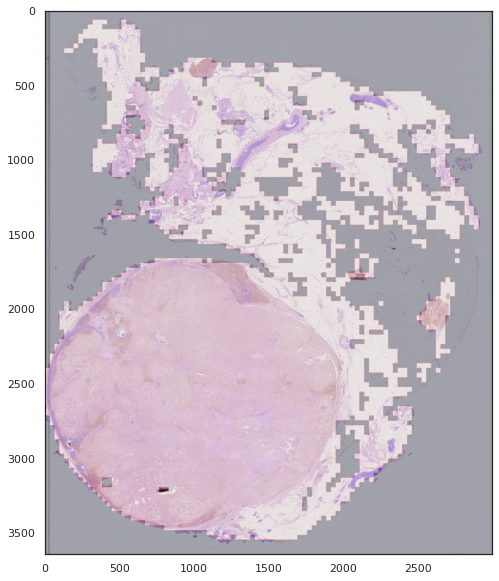

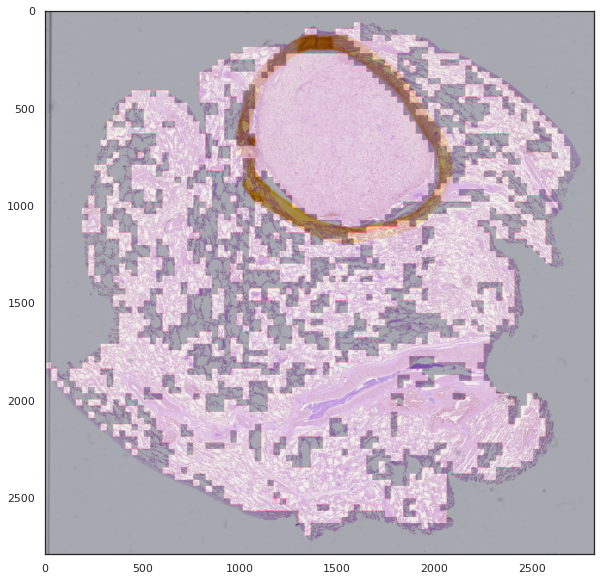

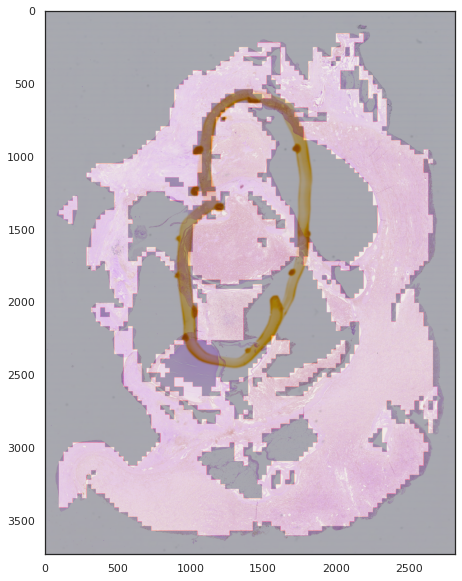

In [115]:
initial_series_idx = 0
for case_id in candidates.sample(3).index.values:
# for case_id in ['IP_19_T00810']:
    # load downscaled WSI for H&E and mIF used in alignment; then load produced displacement field
    loaded_hne_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/hne_series4.npy')
    loaded_mif_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/mif_series4.npy')

    # displacement_path = f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/displacement.pth'
    # displacement = torch.load(displacement_path, map_location='cpu')

    mask_use_path = f'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/histoqc_outputs_ccrcc_51_immunoprofile/{case_id}*/*mask_use*'
    mask_use_path = glob(mask_use_path)[0]
    mask_use_image = plt.imread(mask_use_path)
    
    

    # get seg map
    tile_df = tilewise.set_index('case_id').loc[case_id]
    y_max = loaded_hne_series4.shape[0]//32
    x_max = loaded_hne_series4.shape[1]//32
    
    adjusted_seg_map = get_seg_map(tile_df,'merged_labels', y_max, x_max) + 1
    
    if (y_max == loaded_hne_series4.shape[0]//32) & (x_max == loaded_hne_series4.shape[1]//32):
        # print(f'matched {y_max} with {loaded_hne_series4.shape[0]//32}')
        # print(f'matched {x_max} with {loaded_hne_series4.shape[1]//32}\n')
        pass

    else:
        print('incorrect')
     
    # print(loaded_hne_series4.shape, mask_use_image.shape)
    # print([x/32 for x in loaded_hne_series4.shape[:2]])
    # print(adjusted_seg_map.shape, adjusted_seg_map_prev.shape,'\n')

    resized_seg = resize(adjusted_seg_map, loaded_hne_series4.shape[:2], order=0)  # maybe can KNR on this in same sense??? 
    stacked_resized_seg = np.repeat(np.expand_dims(resized_seg,-1), 3, -1)
    
    plt.imshow(loaded_hne_series4)
    # plt.imshow(resized_seg, alpha=0.3)
    plt.imshow(resized_seg != 0, alpha=0.3 )
    plt.show()

### Now fold in image size matching 

In [184]:
def prod(a,b):
    return a*b
prod(*fixed_image.shape[:2])

10681200

In [ ]:
fixed_image

In [180]:
moving_image.shape

(3555, 2640, 3)


 IP_19_E00218
mIF has larger dimensions
trying to stack...
(7, 3870, 2820)
(3870, 2760, 7) (3735, 2820, 3)
done matching! 
(3870, 2820, 7) (3870, 2820, 3) torch.Size([3870, 2820, 2])
Larger mIF; need to pad H&E


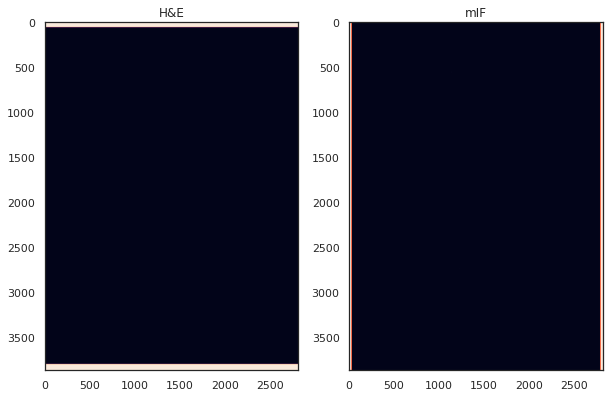

In [263]:
initial_series_idx = 4

results = {}
for case_id in ['IP_19_E00218']:
# for case_id in candidates.sample(5).index.values:
# for case_id in candidates.index.values:
    print('\n', case_id)
    # load downscaled WSI for H&E and mIF used in alignment; then load produced displacement field
    loaded_hne_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/hne_series4.npy')
    loaded_mif_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/mif_series4.npy')



    mask_use_path = f'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/histoqc_outputs_ccrcc_51_immunoprofile/{case_id}*/*mask_use*'
    mask_use_path = glob(mask_use_path)[0]
    mask_use_image = plt.imread(mask_use_path)
    
    

    # get seg map
    tile_df = tilewise.set_index('case_id').loc[case_id]
    y_max = loaded_hne_series4.shape[0]//32
    x_max = loaded_hne_series4.shape[1]//32
    
    adjusted_seg_map = get_seg_map(tile_df,'merged_labels', y_max, x_max) + 1

    resized_seg = resize(adjusted_seg_map, loaded_hne_series4.shape[:2], order=0)  # maybe can KNR on this in same sense??? 
    stacked_resized_seg = np.repeat(np.expand_dims(resized_seg,-1), 3, -1)

    # load displacement
    displacement_path = f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/displacement.pth'
    displacement = torch.load(displacement_path, map_location='cpu')
    
    # do image size matching between series4 mIF and series4-equivalent grade seg map
    hne_channels = list(range(3))
    mif_channels = [2, 3, 4]

    mif_path = glob(f'/mnt/disks/image_data/immunoprofile/raw_files/{case_id}_Scan*.qptiff')[0]
    mif_image = TiffFile(mif_path).series[0].levels[initial_series_idx].asarray()
    
    fixed_image = mif_image.transpose((1,2,0))
    moving_image = stacked_resized_seg

    if prod(*fixed_image.shape[:2]) > prod(*moving_image.shape[:2]):
        print('mIF has larger dimensions')
        larger_mif = True
    else:
        print('H&E has larger dimensions')       
        larger_mif = False
    
    # manually do pseudo 3 channel matching to allow cv2 to work
    mif_stack = []
    for channel in range(7):
        # print(channel)
        temp = fixed_image[..., channel:channel + 1]
        temp = np.repeat(temp, len(hne_channels), -1)
        # print('post repeat: ', temp.shape, moving_image.shape)
        x, moving_image_matched_size = match_image_size(temp, moving_image)
        mif_stack.append(x[..., 0])
    print('trying to stack...')
    print(np.stack(mif_stack).shape)
    fixed_image_matched_size = np.stack(mif_stack).transpose((1, 2, 0))

    
    print(fixed_image.shape, moving_image.shape)
    
    print('done matching! ')
    print(fixed_image_matched_size.shape, moving_image_matched_size.shape, displacement.shape)

    out =  displace_image(moving_image_matched_size, torch.Tensor(displacement), gpu_device=-1)
    results[case_id] = out

    print('Larger mIF; need to pad H&E') if larger_mif else print('Larger H&E; need to trim H&E')
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(moving_image_matched_size[...,0] == 240)
    axes[0].set_title('H&E')

    axes[1].imshow(fixed_image_matched_size[...,0] == 240)
    axes[1].set_title('mIF')
    plt.show()


In [ ]:
# IP_19_E00218 has padding in each img type

Larger mIF; need to pad H&E


Text(0.5, 1.0, 'mIF')

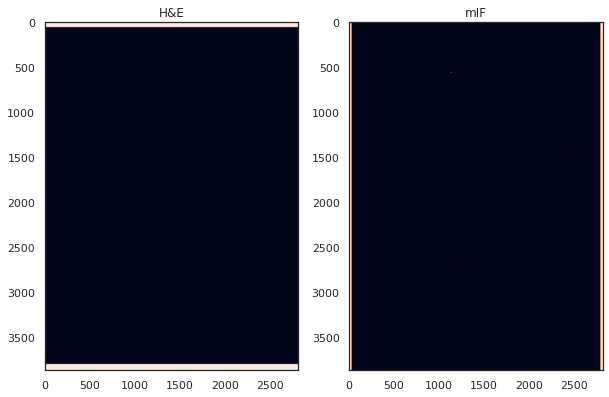

In [264]:
print('Larger mIF; need to pad H&E') if larger_mif else print('Larger H&E; need to trim H&E')
fig, axes = plt.subplots(1,2)
axes[0].imshow(moving_image_matched_size[...,0] > 230)
axes[0].set_title('H&E')

axes[1].imshow(fixed_image_matched_size[...,0] > 230)
axes[1].set_title('mIF')

In [266]:
y_end - y_start

3870

In [267]:
x_end - x_start

2760

In [268]:
out.max()

240


 IP_19_D00209
mIF has larger dimensions
trying to stack...
(7, 3690, 3000)
(3690, 3000, 7) (3510, 2940, 3)
done matching! 
(3690, 3000, 7) (3690, 3000, 3) torch.Size([3690, 3000, 2])
Larger mIF; need to pad H&E


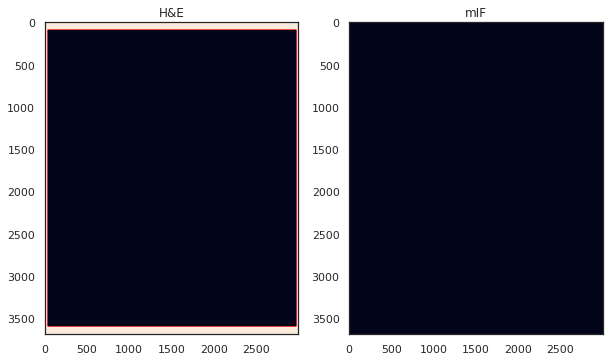

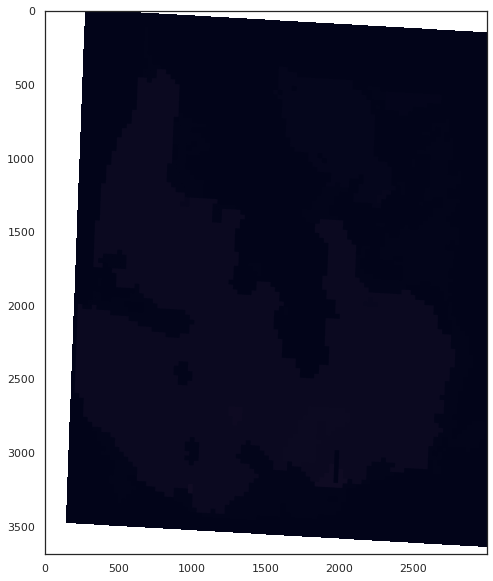

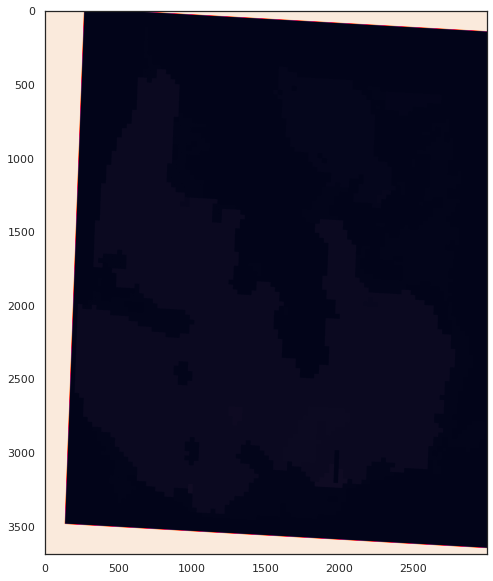

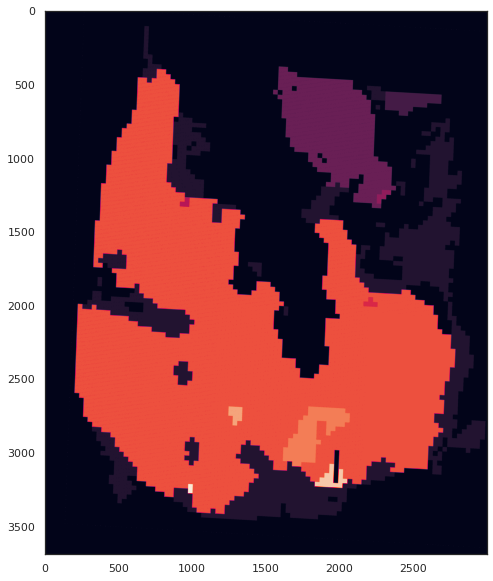


 IP_20_F00356
H&E has larger dimensions
trying to stack...
(7, 3960, 2460)
(3960, 2400, 7) (3960, 2460, 3)
done matching! 
(3960, 2460, 7) (3960, 2460, 3) torch.Size([3960, 2460, 2])
Larger H&E; need to trim H&E


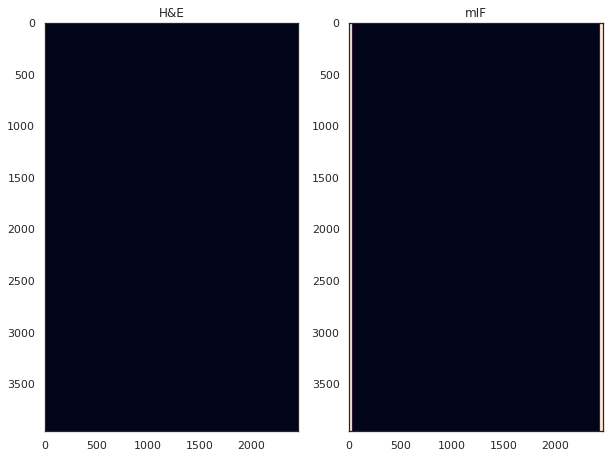

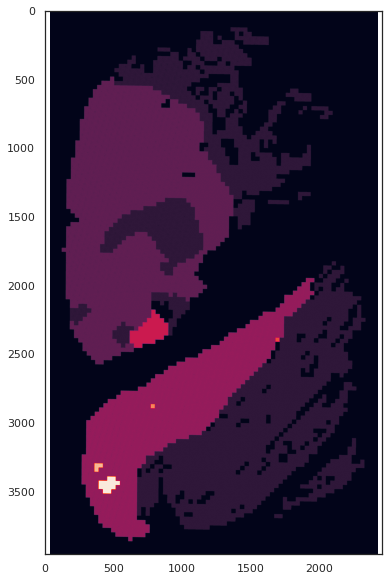

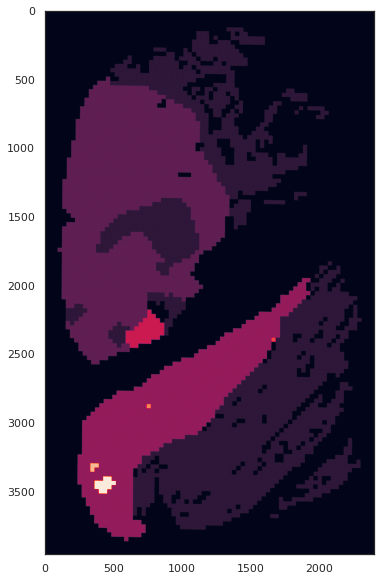

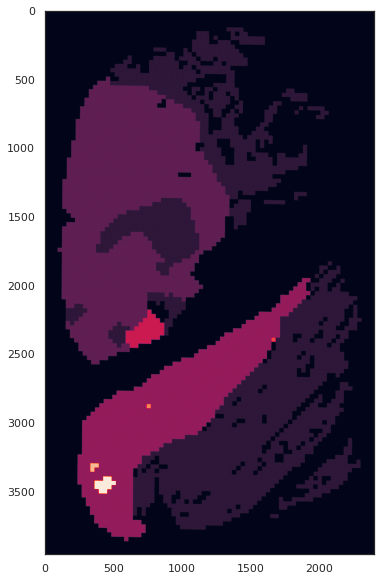


 IP_19_K00367
mIF has larger dimensions
trying to stack...
(7, 3870, 2760)
(3870, 2760, 7) (3555, 2640, 3)
done matching! 
(3870, 2760, 7) (3870, 2760, 3) torch.Size([3870, 2760, 2])
Larger mIF; need to pad H&E


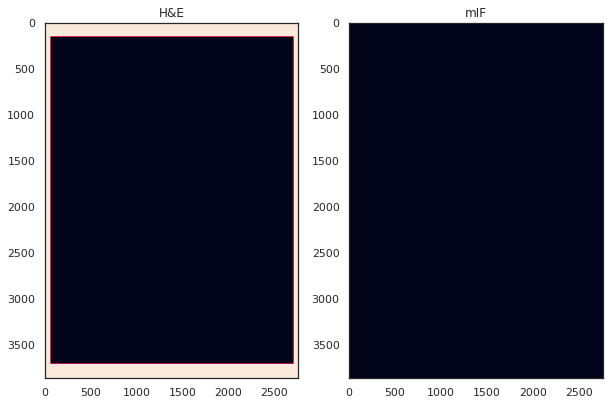

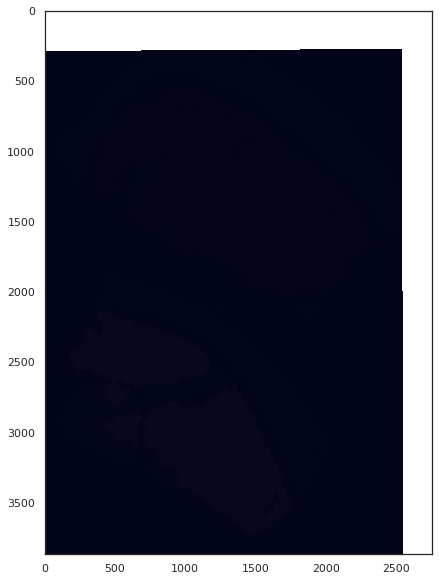

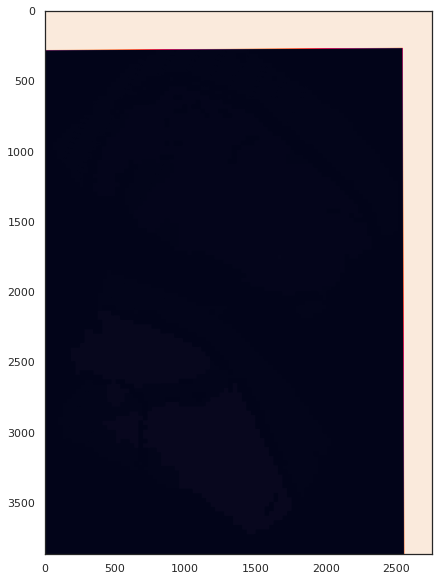

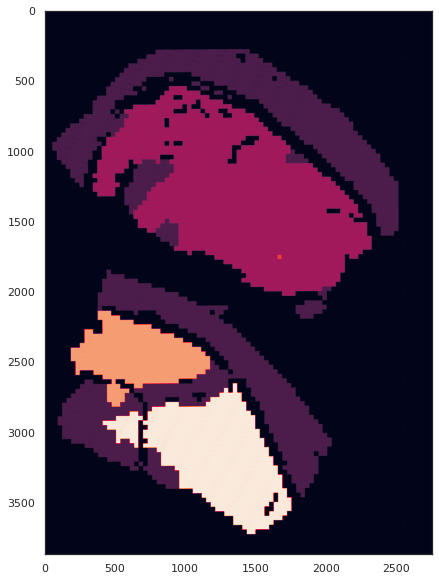


 IP_19_F00568
H&E has larger dimensions
trying to stack...
(7, 3645, 3000)
(3510, 2640, 7) (3645, 3000, 3)
done matching! 
(3645, 3000, 7) (3645, 3000, 3) torch.Size([3645, 3000, 2])
Larger H&E; need to trim H&E


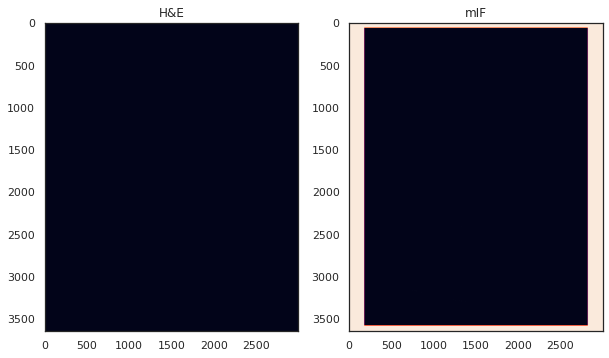

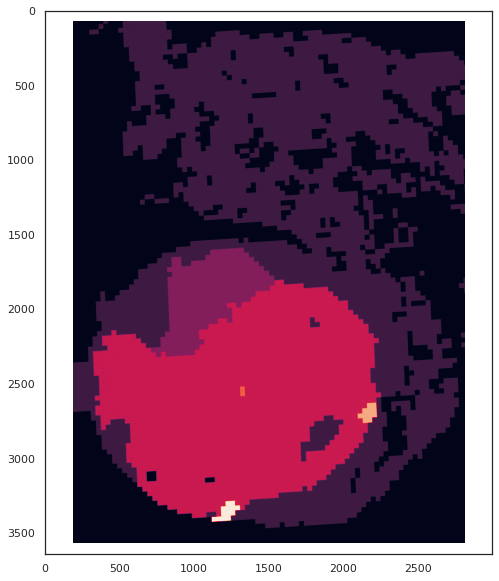

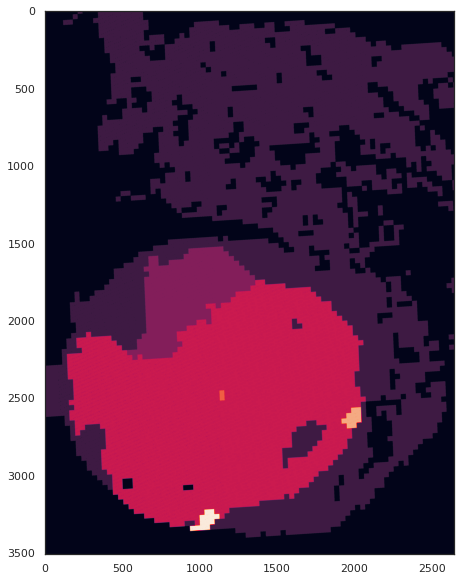

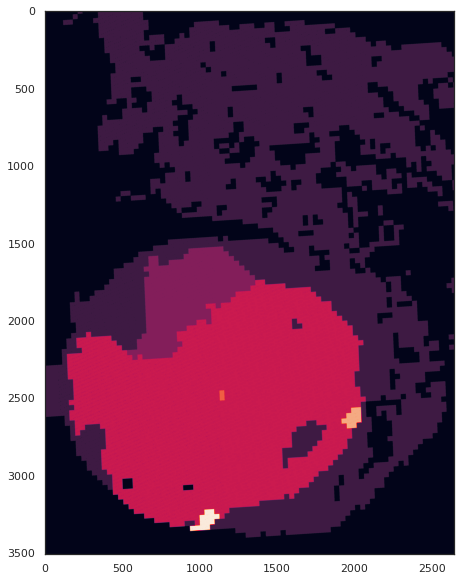


 IP_20_J00195
H&E has larger dimensions
trying to stack...
(7, 3105, 2400)
(2250, 2400, 7) (3105, 2400, 3)
done matching! 
(3105, 2400, 7) (3105, 2400, 3) torch.Size([3105, 2400, 2])
Larger H&E; need to trim H&E


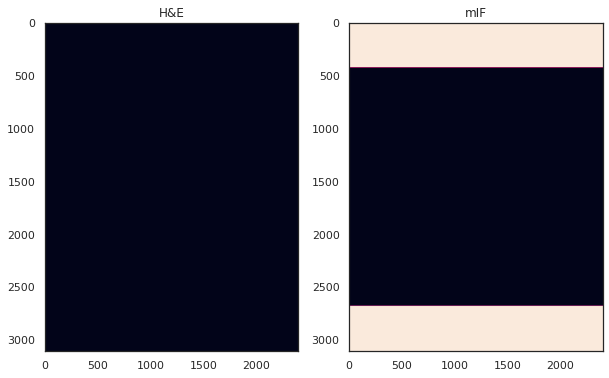

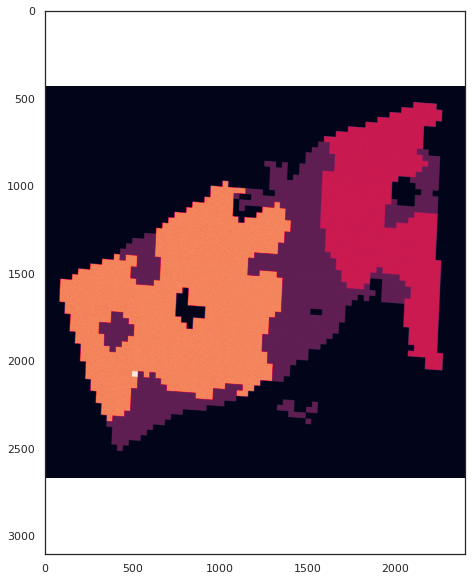

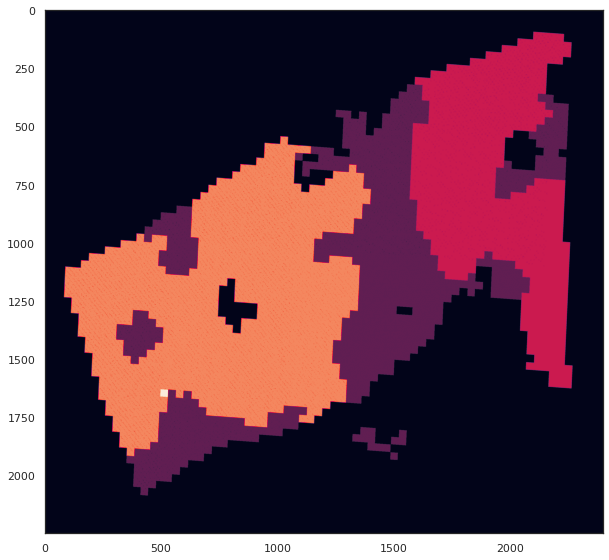

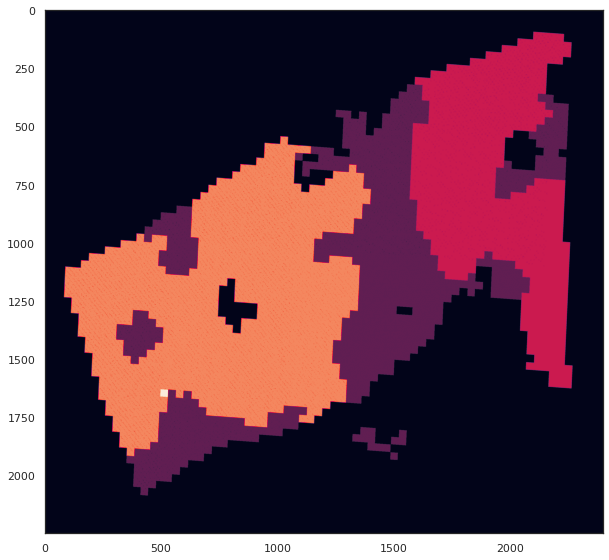


 IP_19_G00562
H&E has larger dimensions
trying to stack...
(7, 4050, 2820)
(3510, 2640, 7) (4050, 2820, 3)
done matching! 
(4050, 2820, 7) (4050, 2820, 3) torch.Size([4050, 2820, 2])
Larger H&E; need to trim H&E


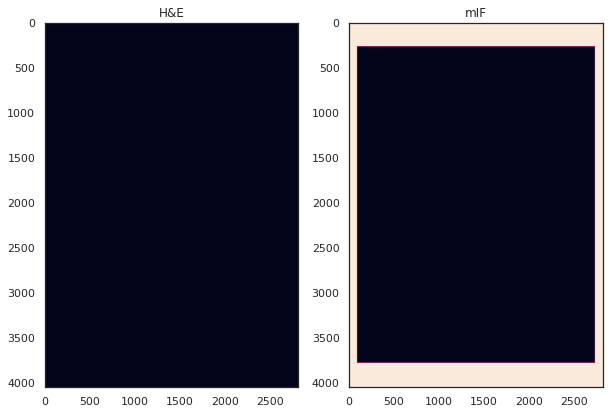

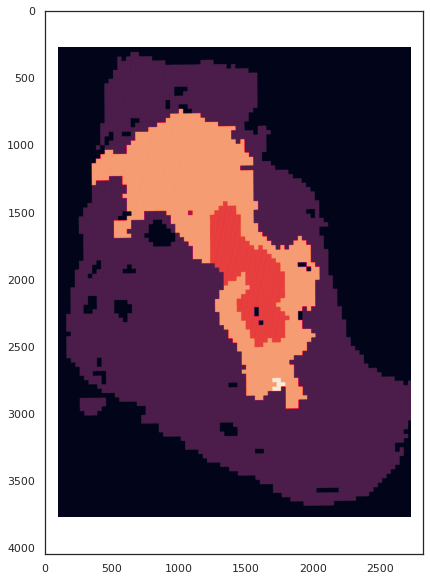

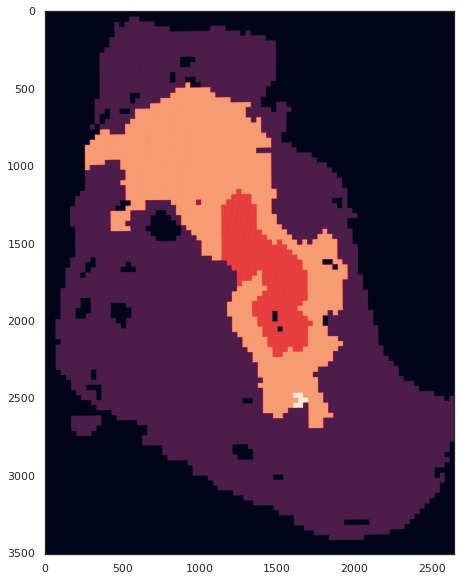

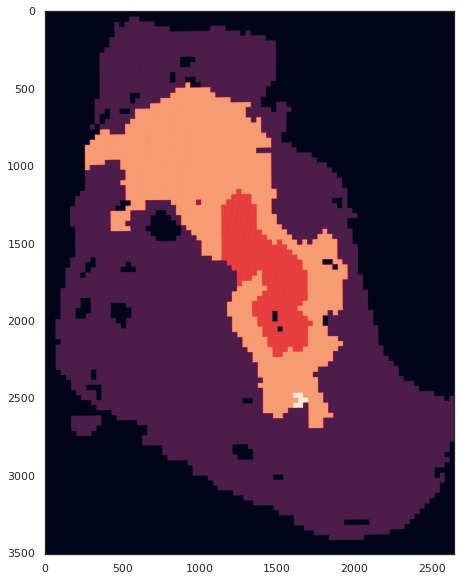


 IP_20_M00245
H&E has larger dimensions
trying to stack...
(7, 3465, 2640)
(2520, 2520, 7) (3465, 2640, 3)
done matching! 
(3465, 2640, 7) (3465, 2640, 3) torch.Size([3465, 2640, 2])
Larger H&E; need to trim H&E


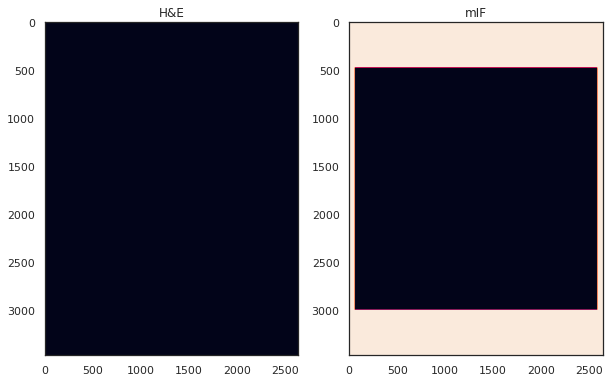

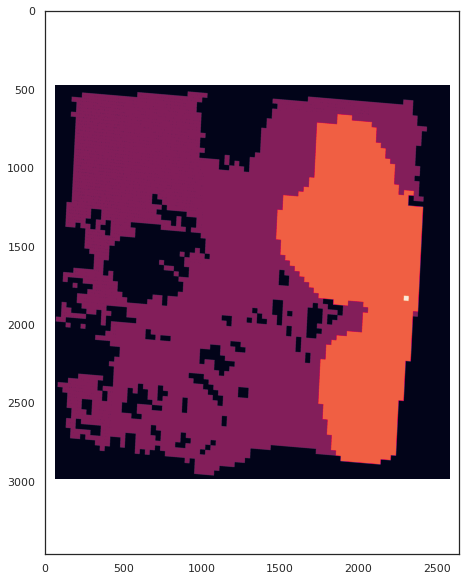

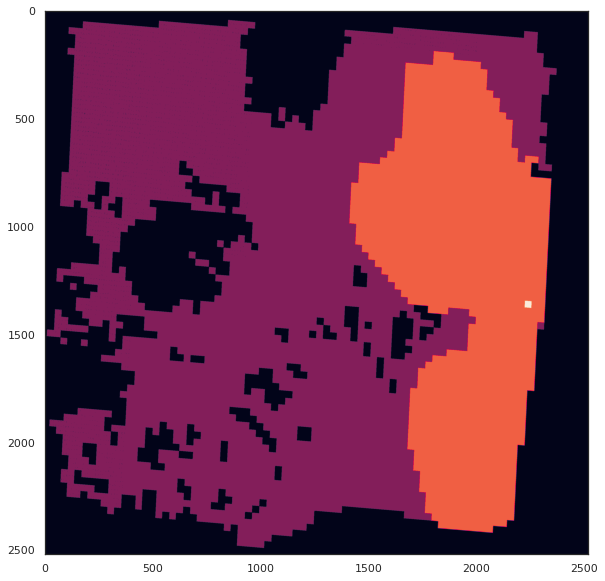

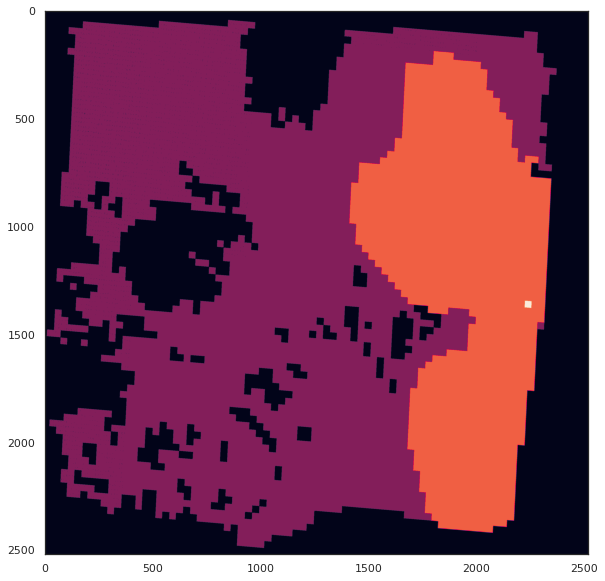


 IP_19_G00660
mIF has larger dimensions
trying to stack...
(7, 3420, 2640)
(3420, 2640, 7) (3285, 2220, 3)
done matching! 
(3420, 2640, 7) (3420, 2640, 3) torch.Size([3420, 2640, 2])
Larger mIF; need to pad H&E


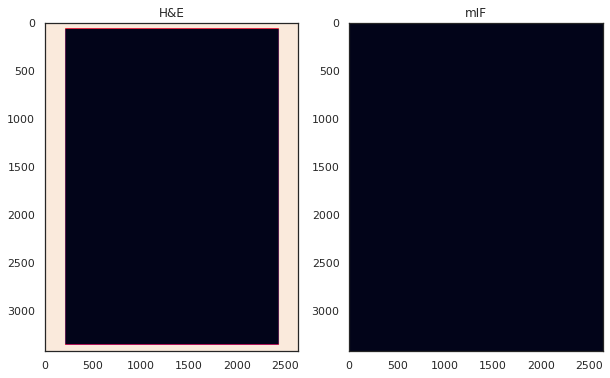

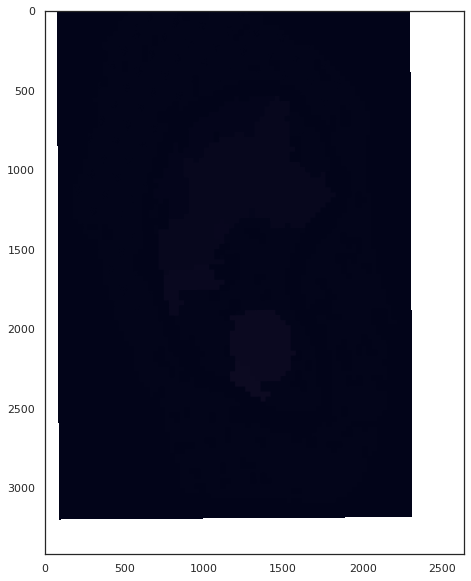

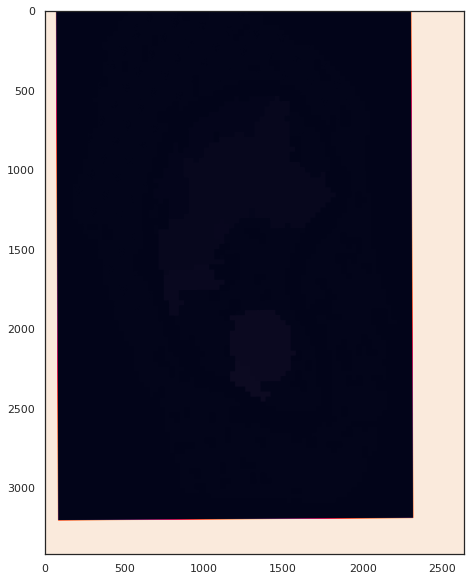

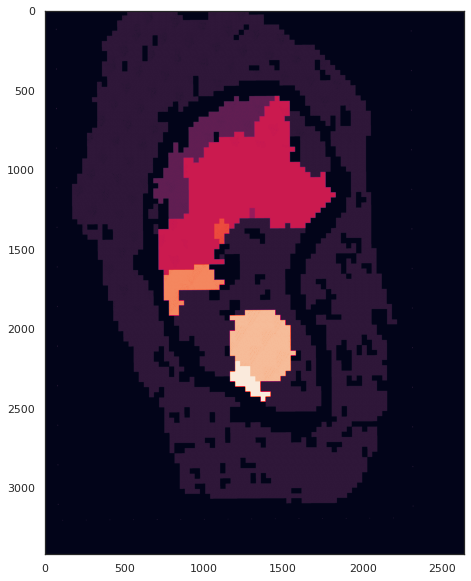


 IP_19_J00132
mIF has larger dimensions
trying to stack...
(7, 2970, 2820)
(2970, 2760, 7) (2790, 2820, 3)
done matching! 
(2970, 2820, 7) (2970, 2820, 3) torch.Size([2970, 2820, 2])
Larger mIF; need to pad H&E


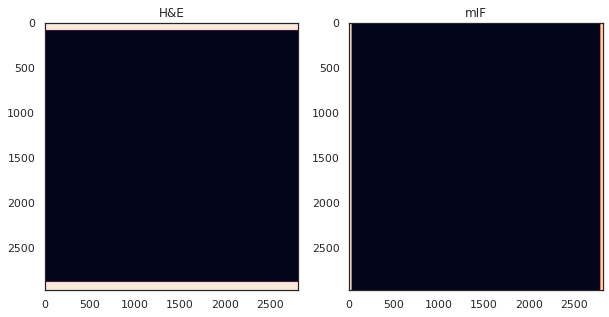

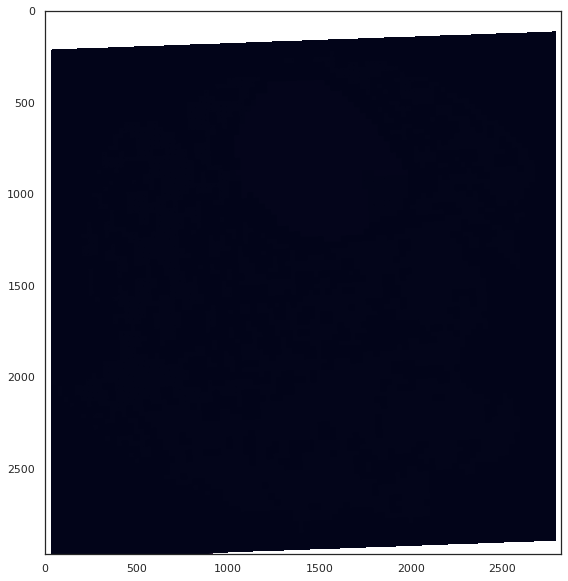

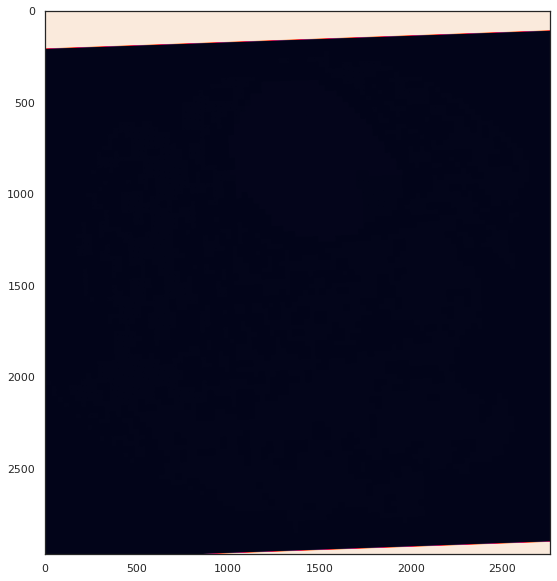

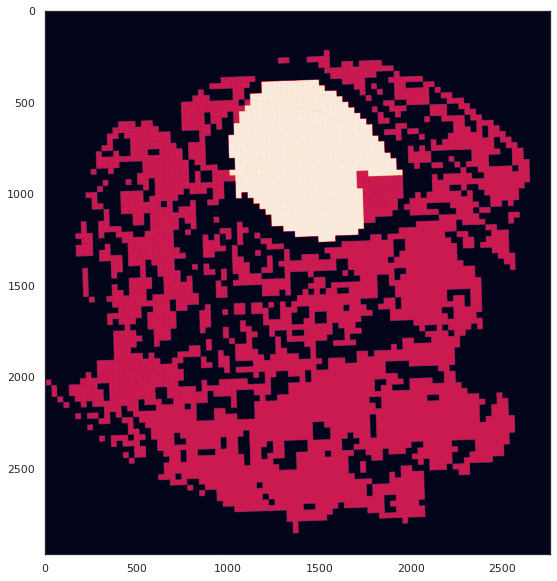


 IP_19_E00218
mIF has larger dimensions
trying to stack...
(7, 3870, 2820)
(3870, 2760, 7) (3735, 2820, 3)
done matching! 
(3870, 2820, 7) (3870, 2820, 3) torch.Size([3870, 2820, 2])
Larger mIF; need to pad H&E


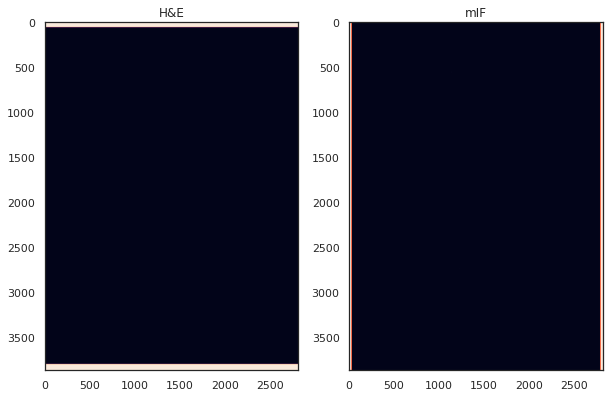

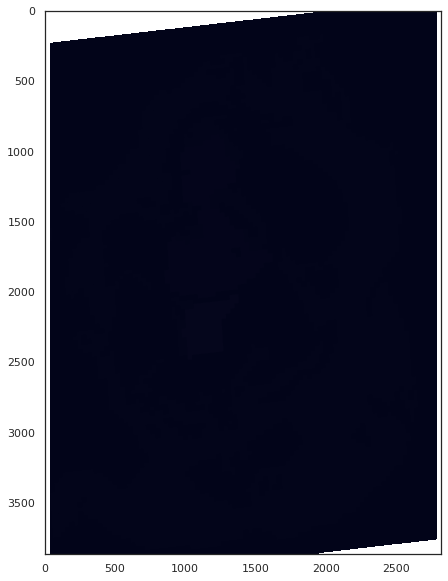

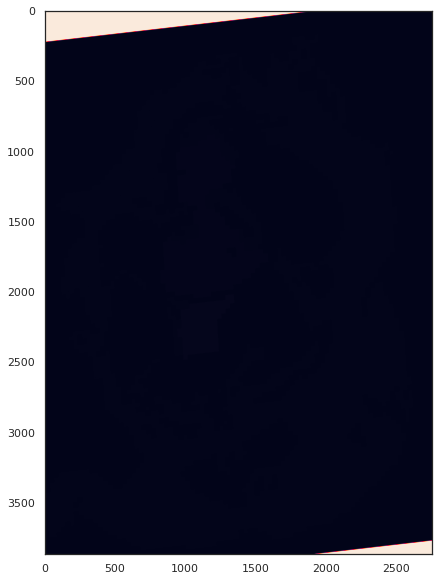

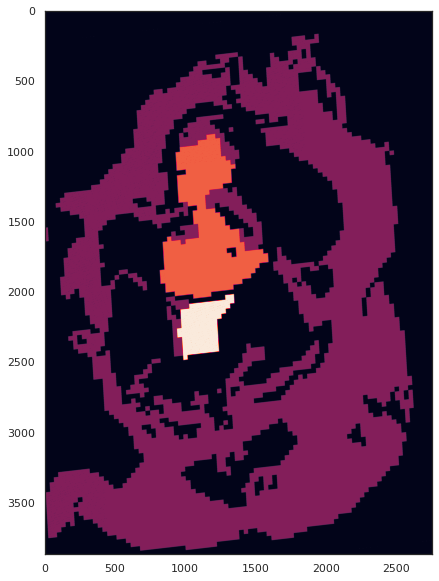


 IP_19_K00058
mIF has larger dimensions
trying to stack...
(7, 3150, 2760)
(3150, 2760, 7) (3060, 2700, 3)
done matching! 
(3150, 2760, 7) (3150, 2760, 3) torch.Size([3150, 2760, 2])
Larger mIF; need to pad H&E


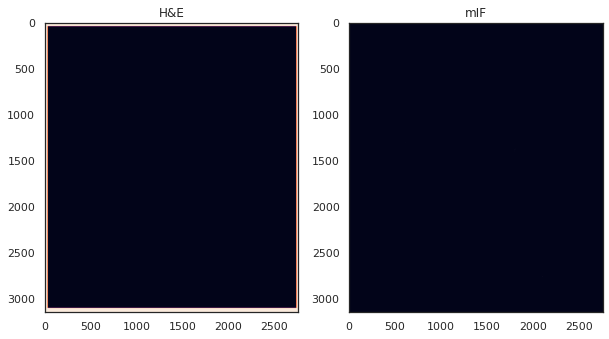

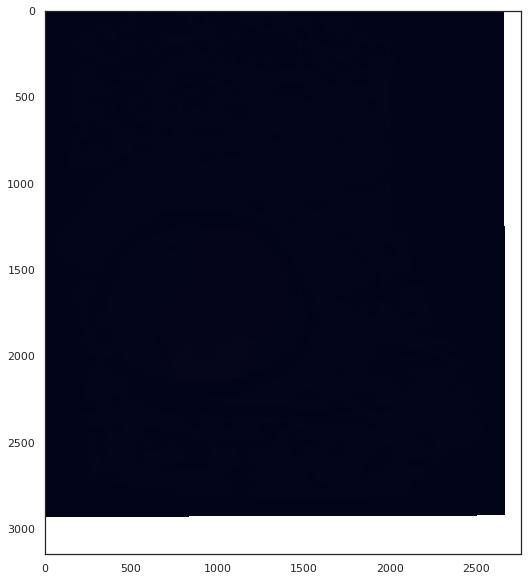

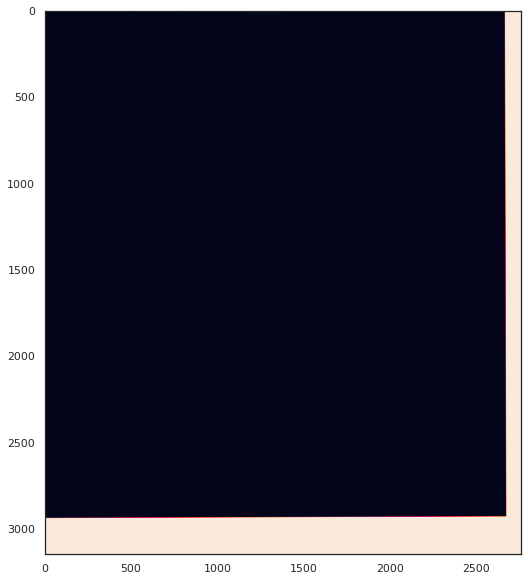

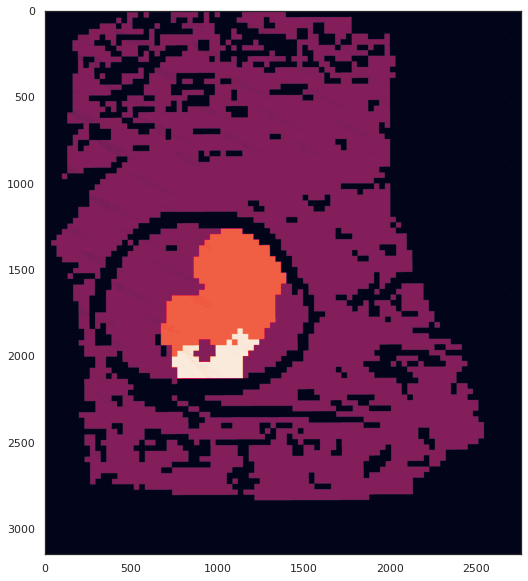


 IP_18_A00093
H&E has larger dimensions
trying to stack...
(7, 3960, 3000)
(3510, 3000, 7) (3960, 2880, 3)
done matching! 
(3960, 3000, 7) (3960, 3000, 3) torch.Size([3960, 3000, 2])
Larger H&E; need to trim H&E


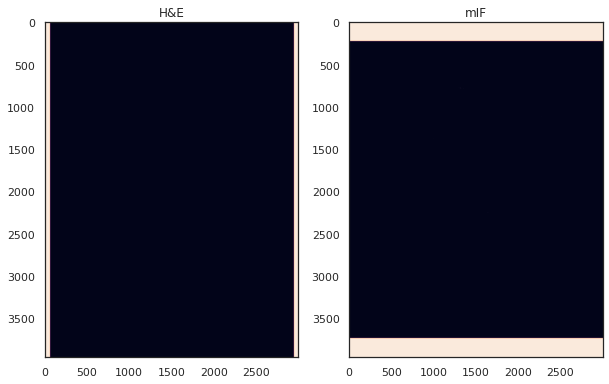

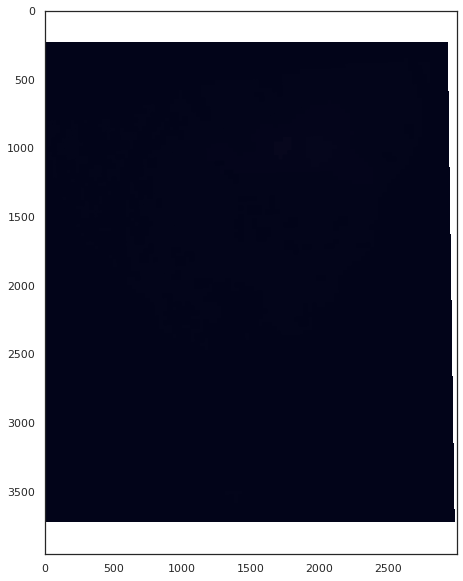

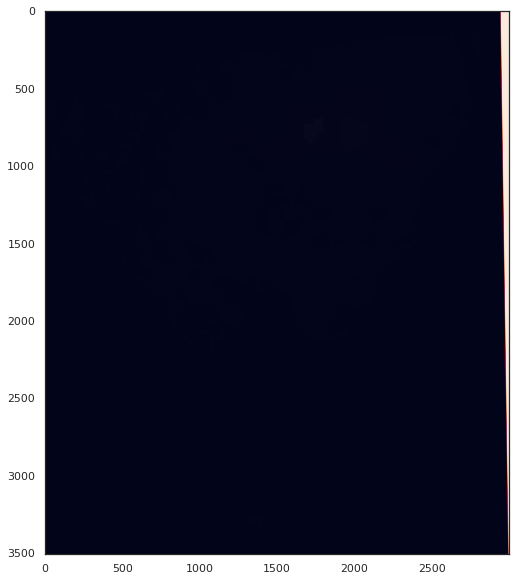

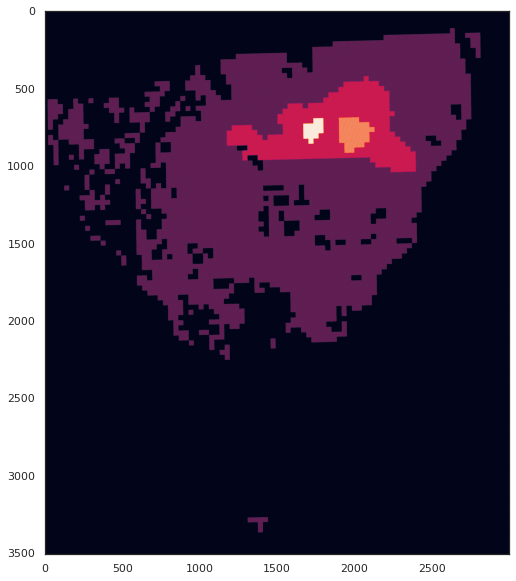


 IP_19_R00053
H&E has larger dimensions
trying to stack...
(7, 3825, 2640)
(3150, 2520, 7) (3825, 2640, 3)
done matching! 
(3825, 2640, 7) (3825, 2640, 3) torch.Size([3825, 2640, 2])
Larger H&E; need to trim H&E


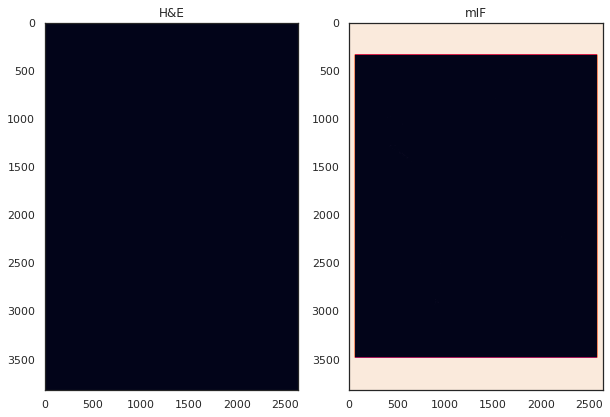

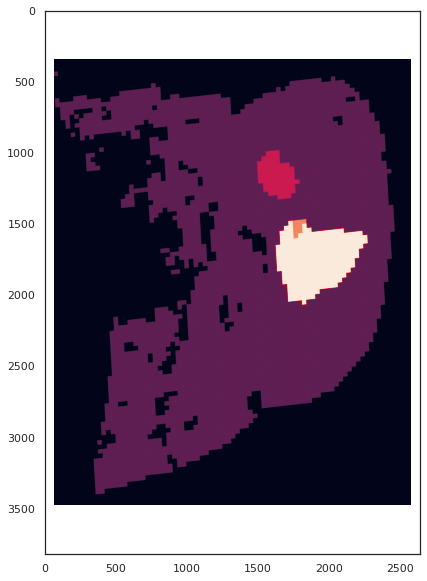

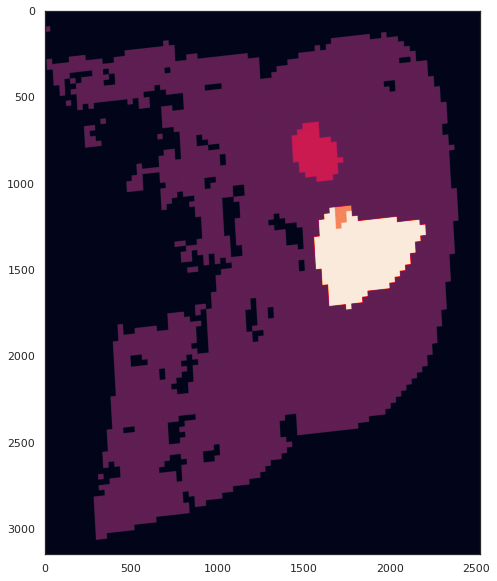

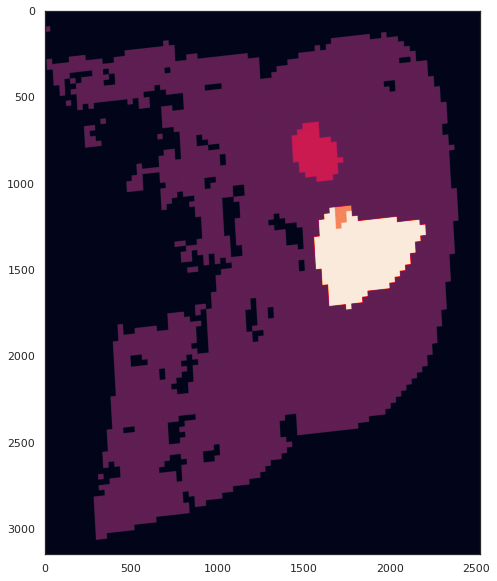


 IP_19_T00810
H&E has larger dimensions
trying to stack...
(7, 2340, 1980)
(2340, 1680, 7) (2340, 1980, 3)
done matching! 
(2340, 1980, 7) (2340, 1980, 3) torch.Size([2340, 1980, 2])
Larger H&E; need to trim H&E


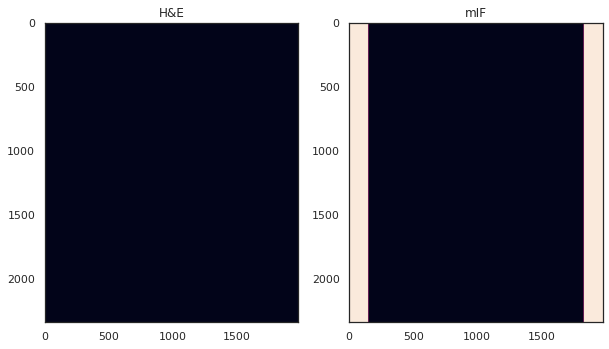

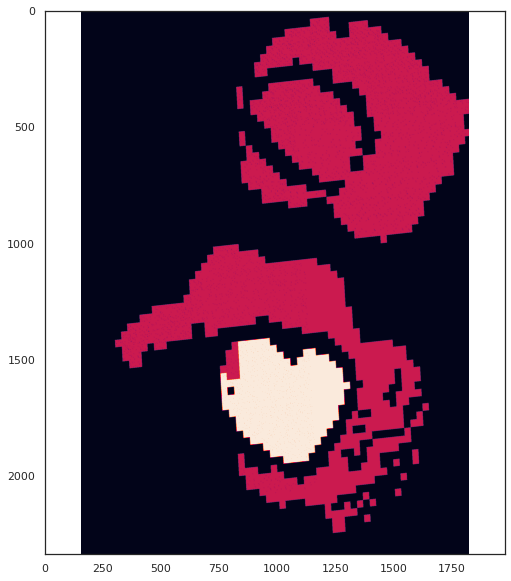

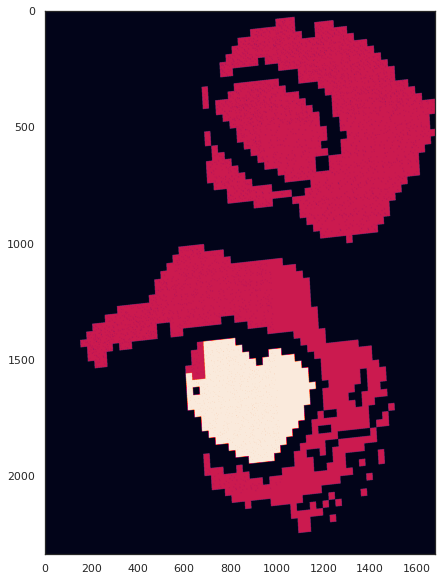

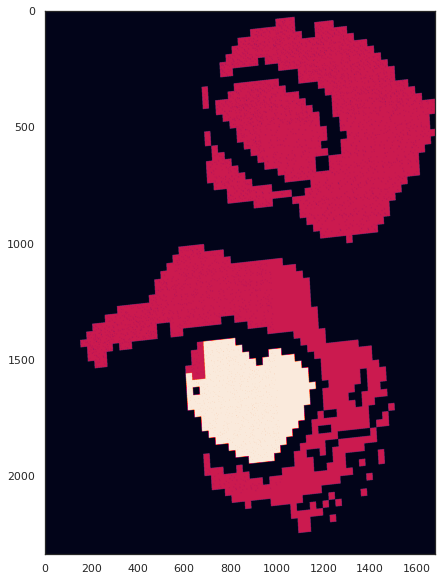

In [350]:
initial_series_idx = 4

results = {}

# for case_id in ['IP_19_E00218']:
# for case_id in candidates.sample(5).index.values:
for case_id in candidates.index.values:
    print('\n', case_id)
    try:
        # load downscaled WSI for H&E and mIF used in alignment; then load produced displacement field
        loaded_hne_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/hne_series4.npy')
        loaded_mif_series4 = np.load(f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/mif_series4.npy')



        mask_use_path = f'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/histoqc_outputs_ccrcc_51_immunoprofile/{case_id}*/*mask_use*'
        mask_use_path = glob(mask_use_path)[0]
        mask_use_image = plt.imread(mask_use_path)



        # get seg map
        tile_df = tilewise.set_index('case_id').loc[case_id]
        y_max = loaded_hne_series4.shape[0]//32
        x_max = loaded_hne_series4.shape[1]//32

        adjusted_seg_map = get_seg_map(tile_df,'merged_labels', y_max, x_max) + 1

        resized_seg = resize(adjusted_seg_map, loaded_hne_series4.shape[:2], order=0)  # maybe can KNR on this in same sense??? 
        stacked_resized_seg = np.repeat(np.expand_dims(resized_seg,-1), 3, -1)

        # load displacement
        displacement_path = f'/mnt/disks/image_data/immunoprofile/out_ab_{case_id}/displacement.pth'
        displacement = torch.load(displacement_path, map_location='cpu')

        # do image size matching between series4 mIF and series4-equivalent grade seg map
        hne_channels = list(range(3))
        mif_channels = [2, 3, 4]

        mif_path = glob(f'/mnt/disks/image_data/immunoprofile/raw_files/{case_id}_Scan*.qptiff')[0]
        mif_image = TiffFile(mif_path).series[0].levels[initial_series_idx].asarray()

        fixed_image = mif_image.transpose((1,2,0))
        moving_image = stacked_resized_seg

        if prod(*fixed_image.shape[:2]) > prod(*moving_image.shape[:2]):
            print('mIF has larger dimensions')
            larger_mif = True
        else:
            print('H&E has larger dimensions')       
            larger_mif = False

        # manually do pseudo 3 channel matching to allow cv2 to work
        mif_stack = []
        for channel in range(7):
            # print(channel)
            temp = fixed_image[..., channel:channel + 1]
            temp = np.repeat(temp, len(hne_channels), -1)
            # print('post repeat: ', temp.shape, moving_image.shape)
            x, moving_image_matched_size = match_image_size(temp, moving_image)
            mif_stack.append(x[..., 0])
        print('trying to stack...')
        print(np.stack(mif_stack).shape)
        fixed_image_matched_size = np.stack(mif_stack).transpose((1, 2, 0))


        print(fixed_image.shape, moving_image.shape)

        print('done matching! ')
        print(fixed_image_matched_size.shape, moving_image_matched_size.shape, displacement.shape)

        out =  displace_image(moving_image_matched_size, torch.Tensor(displacement), gpu_device=-1)

        print('Larger mIF; need to pad H&E') if larger_mif else print('Larger H&E; need to trim H&E')
        fig, axes = plt.subplots(1,2)
        axes[0].imshow(moving_image_matched_size[...,0] == 240)
        axes[0].set_title('H&E')

        axes[1].imshow(fixed_image_matched_size[...,0] == 240)
        axes[1].set_title('mIF')
        plt.show()


        padding_map = fixed_image_matched_size[...,0] == 240
        corners = np.array(np.where(~padding_map)).transpose()

        y_start, x_start = corners[0]
        y_end, x_end = corners[-1]

        y_end += 1
        x_end += 1

        fill = np.ones_like(padding_map)
        fill[y_start:y_end, x_start:x_end] = 0

        out_clone = np.copy(out[...,0])
        plt.imshow(np.ma.masked_array(out_clone.astype(float), (fill == 1) | (out_clone == 240)))
        plt.show()

        # trim to common dims of input mIF image (pre-padding), then fill any "blankspace" produced in displacing H&E image
        trimmed_displaced_grade_map = np.copy(out_clone[y_start:y_end, x_start:x_end])
        plt.imshow(trimmed_displaced_grade_map.astype(float))
        plt.show()

        trimmed_displaced_grade_map[trimmed_displaced_grade_map > moving_image.max()] = 0 
        results[case_id] = trimmed_displaced_grade_map

        plt.imshow(trimmed_displaced_grade_map.astype(float))
        plt.show()
    except:
        print(f'Issue with {case_id}')

In [351]:
len(results)

14

In [354]:
# mkdir /mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/displaced_trimmed_grade_seg_maps

In [355]:
out_dir = '/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/displaced_trimmed_grade_seg_maps'

In [356]:
for k,v in results.items():
    f = os.path.join(out_dir, f'{k}_trimmed_displaced_grade_map.npy')
    np.save(f, v)

In [358]:
ls -lah /mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/displaced_trimmed_grade_seg_maps

total 115M
drwxr-xr-x 2 jupyter jupyter 4.0K Jul 27 19:12 ./
drwxr-xr-x 7 jupyter jupyter 4.0K Jul 27 19:11 ../
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_18_A00093_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_19_D00209_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_19_E00218_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 8.9M Jul 27 19:12 IP_19_F00568_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 8.9M Jul 27 19:12 IP_19_G00562_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 8.7M Jul 27 19:12 IP_19_G00660_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 7.9M Jul 27 19:12 IP_19_J00132_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 8.3M Jul 27 19:12 IP_19_K00058_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_19_K00367_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 7.6M Jul 27 19:12 IP_19_R00053_

### Make KNR maps and push to single DF

In [364]:
for k,v in results.items():
    
    grade_seg_unique = np.unique(v)
    grade_knr_map = pd.DataFrame()

    for idx in grade_seg_unique:
        coords = np.array(np.where(v == idx)).transpose()
        coords = pd.DataFrame(coords, columns=['y','x'])
        coords['label'] = idx
        grade_knr_map = grade_knr_map.append(coords)

    grade_knr_map[['y','x']] = grade_knr_map[['y','x']] * 16
    grade_knr_map['case_id'] = k
    
    f = os.path.join(out_dir, f'{k}_knr_map.pkl')
    grade_knr_map.to_pickle(f)

In [365]:
ls -lah /mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/displaced_trimmed_grade_seg_maps

total 3.2G
drwxr-xr-x 2 jupyter jupyter 4.0K Jul 27 19:16 ./
drwxr-xr-x 7 jupyter jupyter 4.0K Jul 27 19:11 ../
-rw-r--r-- 1 jupyter jupyter 272M Jul 27 19:16 IP_18_A00093_knr_map.pkl
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_18_A00093_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 286M Jul 27 19:16 IP_19_D00209_knr_map.pkl
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_19_D00209_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 276M Jul 27 19:16 IP_19_E00218_knr_map.pkl
-rw-r--r-- 1 jupyter jupyter  11M Jul 27 19:12 IP_19_E00218_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 239M Jul 27 19:16 IP_19_F00568_knr_map.pkl
-rw-r--r-- 1 jupyter jupyter 8.9M Jul 27 19:12 IP_19_F00568_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 239M Jul 27 19:16 IP_19_G00562_knr_map.pkl
-rw-r--r-- 1 jupyter jupyter 8.9M Jul 27 19:12 IP_19_G00562_trimmed_displaced_grade_map.npy
-rw-r--r-- 1 jupyter jupyter 233M Jul 27 19:16 IP_19_G00660_knr_map.

### Write separated TIFs per channel 

In [366]:
mkdir /mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs

In [10]:
qptiff_channels = ['dapi', 'foxp3', 'tumor_specific', 'cd8', 'pd1', 'pdl1','autofluorescence']

In [1]:
# conda install -c conda-forge pyvips

In [2]:
import pyvips

In [12]:
# write channel-wise flattened TIFs of cropped full resolution mIF data
out_dir = '/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs'
initial_series_idx = 0 # full res needed now

for case_id in candidates.index.values:
    print('\n', case_id)
    mif_path = glob(f'/mnt/disks/image_data/immunoprofile/raw_files/{case_id}_Scan*.qptiff')[0]
    full_res_mif = TiffFile(mif_path).series[0].levels[initial_series_idx].asarray()
    
    # save specific membrane image 
    img = pyvips.Image.new_from_array(full_res_mif[[2,3]].transpose((1,2,0)))
    f = os.path.join(out_dir, f'{case_id}_membrane.tif')
    print(f)
    img.write_to_file(f)

    # save channel specific images
    for idx, channel in enumerate(qptiff_channels):
        try:
            img = pyvips.Image.new_from_array(full_res_mif[idx])
            f = os.path.join(out_dir, f'{case_id}_{idx}_{channel}.tif')
            print(f)
            img.write_to_file(f)
        except:
            print(f'Ran into error for {case_id}, {channel}')



 IP_19_D00209
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_membrane.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_0_dapi.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_1_foxp3.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_2_tumor_specific.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_3_cd8.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_4_pd1.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_5_pdl1.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_19_D00209_6_autofluorescence.tif

 IP_20_F00356
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_20_F00356_membrane.tif
/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/split_tifs/IP_20_F00356_0_dapi

In [17]:
pd.Series(candidates.index.values).to_csv('~/mesmer_case_ids_to_run_14_ccrcc.txt', index=False, header=False)

In [ ]:
stop

### (post-segmentation and phenotyping) Map grade segment labels to pixels at full scale again

In [ ]:
grade_seg_unique = np.unique(trimmed_grade_map_sub)

grade_knr_map = pd.DataFrame()

for idx in grade_seg_unique:
    coords = np.array(np.where(trimmed_grade_map_sub == idx)).transpose()
    coords = pd.DataFrame(coords, columns=['y','x'])
    coords['label'] = idx
    grade_knr_map = grade_knr_map.append(coords)

grade_knr_map[['y','x']] = grade_knr_map[['y','x']] * 16

In [ ]:
arcsinh_quant_agg_annotated = arcsinh_quant_agg.copy()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = 4
dist_type = 'uniform'
knr = KNeighborsRegressor(n_neighbors=n_neighbors, weights=dist_type)
knr.fit(grade_knr_map[['x','y']].values,grade_knr_map['label'].values)

In [ ]:
knr_preds = knr.predict(arcsinh_quant_agg_annotated[['fov_x_full_scale','fov_y_full_scale']].values)

In [ ]:
# for uid in ids_to_run:

#     # load qptiff image 
#     load_fn....

#     # detect whether trimming necessary
#     trim_detection...
    
#         # run trimming

#         # save coordinates of trimmed mIF image 

#         ### maybe something like "coords relative to full res" and "coords relative to series4 displacement res"

#         # make KNR mapping for trimmed image space 


#     # write channel-wise flattened TIFs of cropped full resolution mIF data

#         # for idx, channel in enumerate(qptiff_channels):
#         #     img = pyvips.Image.new_from_array(cropped_full_res[idx])
#         #     img.write_to_file(f'./IP_19_F00568_cropped_{idx}_{channel}.tif')

### Non-Trimming Approach Might Be Easiest / More Efficient

In [ ]:
for uid in ids_to_run:

    # load qptiff image 
    load_fn....

    ### maybe something like "coords relative to full res" and "coords relative to series4 displacement res"

    # make KNR mapping for trimmed image space 


    # write channel-wise flattened TIFs of cropped full resolution mIF data

        # for idx, channel in enumerate(qptiff_channels):
        #     img = pyvips.Image.new_from_array(cropped_full_res[idx])
        #     img.write_to_file(f'./IP_19_F00568_cropped_{idx}_{channel}.tif')

In [ ]:
xxxxx aside 

---
### Note: since we converted the HnE qptiffs to pseudo-Aperio SVS by changing their header, we have to access them differently now via TiffFile 
- the lowest resolution packed into the converted files would be equivalent to max res / 4; previously `series4` was max res / 16.

In [ ]:
initial_series_idx = 4

mif_path = '/mnt/disks/image_data/immunoprofile/raw_files/IP_19_T00810_Scan1.qptiff'
mif_image = TiffFile(mif_path).series[0].levels[initial_series_idx].asarray()
mif_image.shape

(7, 2340, 1680)

In [72]:
hne_path = '/mnt/disks/image_data/immunoprofile/raw_files/IP_19_T00810_HnE_Scan1.qptiff'
hne_image = TiffFile(hne_path).series[0].levels[initial_series_idx].asarray()
hne_image.shape

(37440, 31680, 3)

In [118]:
for series in TiffFile(mif_path).series:
    print('\n',series.shape)
    print(len(series.levels))
    for lvl in series.levels:
        print(lvl.shape)


 (7, 37440, 26880)
6
(7, 37440, 26880)
(7, 18720, 13440)
(7, 9360, 6720)
(7, 4680, 3360)
(7, 2340, 1680)
(7, 1170, 840)

 (292, 210, 3)
1
(292, 210, 3)

 (4016, 2080, 3)
1
(4016, 2080, 3)

 (448, 520, 3)
1
(448, 520, 3)


In [119]:
26880/16

1680.0

In [116]:
for series in TiffFile(hne_path).series:
    print('\n',series.shape)
    print(len(series.levels))
    for lvl in series.levels:
        print(lvl.shape)


 (37440, 31680, 3)
1
(37440, 31680, 3)

 (292, 247, 3)
1
(292, 247, 3)

 (18720, 15840, 3)
1
(18720, 15840, 3)

 (9360, 7920, 3)
1
(9360, 7920, 3)


In [54]:
xxxxxxx

NameError: name 'xxxxxxx' is not defined